-------------------------------------------------------
Max upper bound on time: 0.0002869878 

Min upper bound on time: 0.00022128540000000002 

Average upper bound on time: 0.00024843090714285715 

Max m value: 1024.0 

Min m value: 512.0 

Average m value: 950.8571428571429 



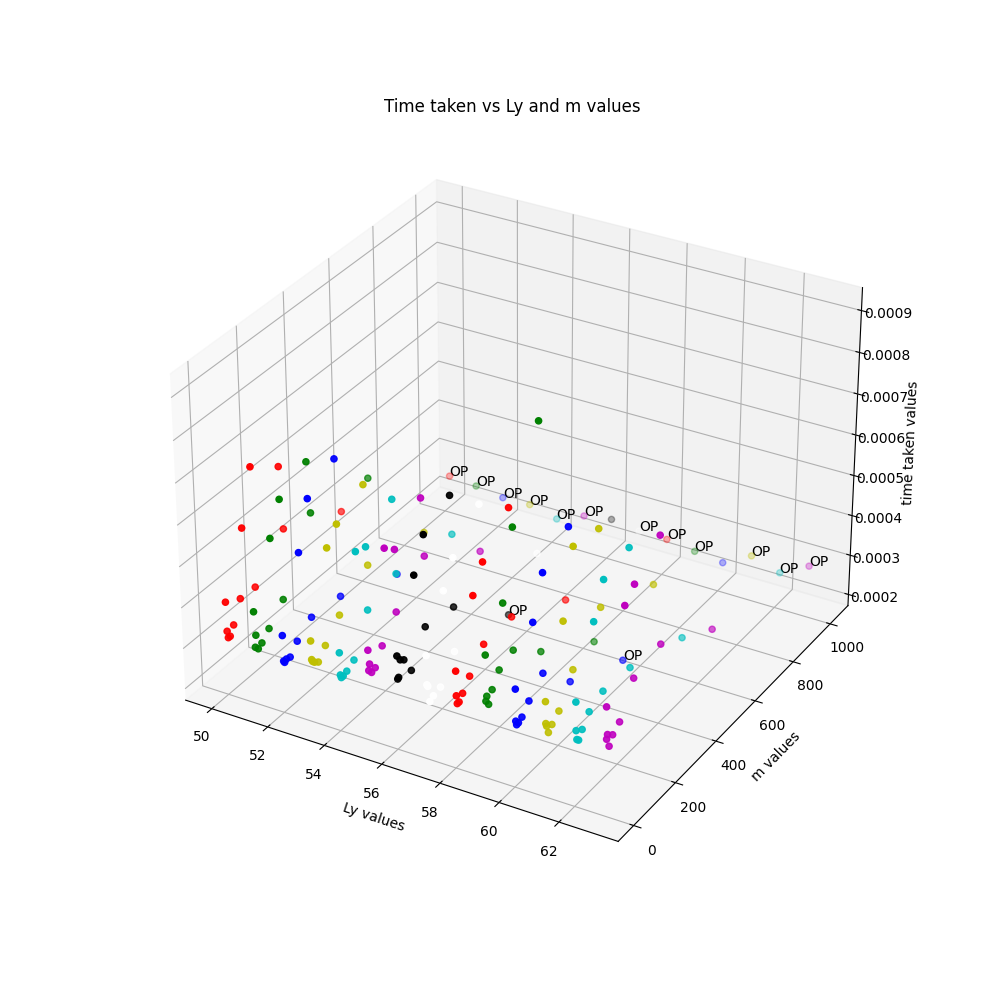

In [37]:
#!/usr/bin/env python3

import sys, getopt
import numpy as np
from math import *
import os
import subprocess
import shlex
import regex as re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget


def match_pattern(pattern, line):
	m = []
	matches = re.findall(pattern, line)
	for match in matches:
		m.append(float(match[2:]))
	return m

def average_columns(data):
    # Transpose the 2D list to get the columns as rows
    transposed_data = [[row[i] for row in data] for i in range(len(data[0]))]

    # Calculate the sum of each column and divide by the number of rows
    result = [sum(column) / len(data) for column in transposed_data]

    return result

def plot(x,y,z,thread):
	# Create the figure and 3D axis
	fig = plt.figure(figsize = (10,10))
	ax = fig.add_subplot(111, projection='3d')

	# Plot the data
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'][:len(x)]

	optimal_t = []
	optimal_y = []
	for i in range(len(x)):
		max_time = float(1e5)
		max_m = 0
		for j in range(len(y[i])):
			if max_time > z[i][j]:
				max_m = y[i][j]
				max_time = z[i][j]
		optimal_t.append(max_time)
		optimal_y.append(max_m)

	print("Max upper bound on time:", max(optimal_t),"\n")
	print("Min upper bound on time:", min(optimal_t),"\n")
	print("Average upper bound on time:", sum(optimal_t)/len(optimal_t),"\n")

	print("Max m value:", max(optimal_y),"\n")
	print("Min m value:", min(optimal_y),"\n")
	print("Average m value:", sum(optimal_y)/len(optimal_y),"\n")
	
	for i in range(len(x)):
		ax.scatter(x[i], y[i], z[i], c=colors[i%8], marker='o')
		ax.text(x[i], optimal_y[i], optimal_t[i], "OP", size=10, zorder=1, color='k')
	
	#cb = plt.colorbar(ax1, pad=0.2)

	# Set axis labels
	ax.set_title('Time taken vs Ly and m values')
	#ax.set_xticks(x)
	ax.set_ylabel('m values')
	ax.set_zlabel('time taken values')
	ax.set_xlabel('Ly values')

	# Show the plot
	plt.savefig("test.png")
	#plt.show()

thread = [[],[],[],[],[],[],[],[]]
ly_values = [j for j in range(50, 64)]
final_m_values = []
final_time_values = []
t_array = [8]
random_averages = 10


for thread in t_array:
	final_m_values = []
	final_time_values = []
	for i in ly_values:
		#print("Thread ", thread, ": ", end=" ")
		#print("Ly=", i, end="\n")
		averaged_columns_m = []
		averaged_columns_time = []
		for k in range(random_averages):
			string = "./hybridconv2 -Lx=512 -Ly=" + str(i) + " -Mx=1024 -My=" + str(2*i) + " -t -R -T=" + str(thread)
			cmd = subprocess.run(shlex.split(string), capture_output=True, text=True)
			string = cmd.stdout

			pattern = "m="
			matches = re.finditer(pattern, string)
			for match in matches:
				# Get the starting index of the match

				start = match.start()
				if int(start) < 100:
					# Get the line number by counting the number of newline characters before the match

					line_num = string[:start].count("\n") + 1
					line_start = string.rfind("\n", 0, start) + 1
					line_end = string.find("Optimal time: ", start)
					line = string[line_start:line_end]

					# Extract the values as a float and append to a list
					m_values = match_pattern("m=\d+", line)
					time_values = match_pattern("t=\d+\.\d+", line)

			averaged_columns_m.append(m_values)
			averaged_columns_time.append(time_values)

		final_m_values.append(average_columns(averaged_columns_m))
		final_time_values.append(average_columns(averaged_columns_time))
				
	print("-------------------------------------------------------")
	plot(ly_values,final_m_values,final_time_values,thread)